In [1]:
import json
import urllib.request
import os
os.chdir("/home/tales/dev/master/mdc_analysis/")
print("working dir", os.getcwd())

from src.dao import csv_dao
from src.dao import objects_dao
from src.entity.stop_region import StopRegionGroup, sr_row_to_stop_region
from src.utils.others import remove_list_elements
from src.taxonomy.category_mapping import CategoryMapper
from src.exceptions.exceptions import NoCategoryMatched, NotValidTypes
from src.utils.time_utils import human_time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

working dir /home/tales/dev/master/mdc_analysis


## Loading

In [2]:
users_srg = objects_dao.load_all_stop_region_group_object()

Loading user_id: 6189 - 1 out of 163
Loading user_id: 5936 - 2 out of 163
Loading user_id: 6087 - 3 out of 163
Loading user_id: 5973 - 4 out of 163
Loading user_id: 6085 - 5 out of 163
Loading user_id: 6074 - 6 out of 163
Loading user_id: 6012 - 7 out of 163
Loading user_id: 5982 - 8 out of 163
Loading user_id: 5948 - 9 out of 163
Loading user_id: 5974 - 10 out of 163
Loading user_id: 6090 - 11 out of 163
Loading user_id: 6199 - 12 out of 163
Loading user_id: 6068 - 13 out of 163
Loading user_id: 6024 - 14 out of 163
Loading user_id: 5976 - 15 out of 163
Loading user_id: 6094 - 16 out of 163
Loading user_id: 5941 - 17 out of 163
Loading user_id: 5995 - 18 out of 163
Loading user_id: 5962 - 19 out of 163
Loading user_id: 6093 - 20 out of 163
Loading user_id: 6033 - 21 out of 163
Loading user_id: 6079 - 22 out of 163
Loading user_id: 6038 - 23 out of 163
Loading user_id: 6175 - 24 out of 163
Loading user_id: 6042 - 25 out of 163
Loading user_id: 5924 - 26 out of 163
Loading user_id: 6083

## How many places have multiple semantics ?

In [3]:
semantics_len = {}
for user_id in list(users_srg.keys()):
    semantics_user_len = users_srg[user_id].sequence_report(only_simple_cols=False)["sr_semantics"].apply(lambda semantics : len(semantics))
    semantics_len[user_id] = semantics_user_len

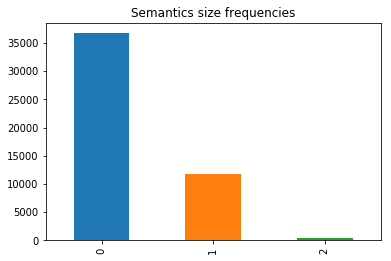

In [4]:
total = 0
all_lens = pd.Series()

for user_id in list(users_srg.keys()):
    all_lens = all_lens.append(semantics_len[user_id])

all_lens.value_counts().plot.bar(title="Semantics size frequencies")

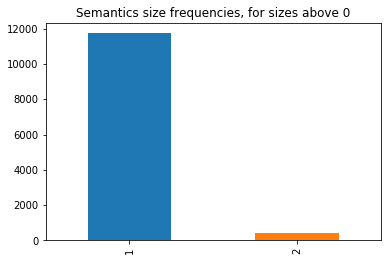

In [5]:
all_lens[all_lens > 0].value_counts().plot.bar(title="Semantics size frequencies, for sizes above 0")

In [6]:
"{}% of semantics are size 2 (out of semantics with size above 0)".format((all_lens[all_lens > 0].value_counts()[2] / len(all_lens[all_lens > 0])).round(4) * 100)

'3.49% of semantics are size 2 (out of semantics with size above 0)'

## 

In [19]:
seq = users_srg["6087"].sequence_report(only_simple_cols=False)
seq.head()

,delta_t_from_last_sr,distance,last_sr,last_sr_semantics,last_sr_type,sr,sr_end_time,sr_semantics,sr_start_time,sr_type,stay_time_h,tags
0,87159.000,3137.900,6087_0,[HOME],[[moving_company]],6087_1,1264614685.000,"[HOME, WORK]",1264585574.000,[[beauty_salon]],8.086,"[HOME, WORK]"
1,2109.000,5553.400,6087_1,"[HOME, WORK]",[[beauty_salon]],6087_2,1264619249.000,[],1264616794.000,"[[finance], [lawyer], [lawyer], [finance]]",0.682,"[finance, lawyer, lawyer, finance]"
2,59.000,104.300,6087_2,[],"[[finance], [lawyer], [lawyer], [finance]]",6087_3,1264622384.000,[],1264619308.000,"[[locality, political], [clothing_store, store...",0.854,"[locality, political, clothing_store, store, m..."
3,48987.000,5646.500,6087_3,[],"[[locality, political], [clothing_store, store...",6087_4,1264700234.000,"[HOME, WORK]",1264671371.000,[[beauty_salon]],8.018,"[HOME, WORK]"
4,1482.000,3161.400,6087_4,"[HOME, WORK]",[[beauty_salon]],6087_5,1264756827.000,[HOME],1264701716.000,[[moving_company]],15.309,[HOME]


In [10]:
sr_start_time_h = seq["sr_start_time"].apply(human_time)
sr_end_time_h = seq["sr_end_time"].apply(human_time)

seq["start_weekday"] = sr_start_time_h.apply(lambda x : x["weekday"])
seq["start_date"] = sr_start_time_h.apply(lambda x : x["datetime"].split(" ")[0])
seq["start_time"] = sr_start_time_h.apply(lambda x : x["datetime"].split(" ")[1])

seq["end_date"] = sr_end_time_h.apply(lambda x : x["datetime"].split(" ")[0])
seq["end_time"] = sr_end_time_h.apply(lambda x : x["datetime"].split(" ")[1])
seq["end_weekday"] = sr_end_time_h.apply(lambda x : x["weekday"])
del seq["sr_start_time"]
del seq["sr_end_time"]

seq.head()

,delta_t_from_last_sr,distance,last_sr,last_sr_semantics,last_sr_type,sr,sr_semantics,sr_type,stay_time_h,tags,start_weekday,start_date,start_time,end_date,end_time,end_weekday
0,87159.000,3137.900,6087_0,[HOME],[[moving_company]],6087_1,"[HOME, WORK]",[[beauty_salon]],8.086,"[HOME, WORK]",Wednesday,2010-01-27,09:46:14,2010-01-27,17:51:25,Wednesday
1,2109.000,5553.400,6087_1,"[HOME, WORK]",[[beauty_salon]],6087_2,[],"[[finance], [lawyer], [lawyer], [finance]]",0.682,"[finance, lawyer, lawyer, finance]",Wednesday,2010-01-27,18:26:34,2010-01-27,19:07:29,Wednesday
2,59.000,104.300,6087_2,[],"[[finance], [lawyer], [lawyer], [finance]]",6087_3,[],"[[locality, political], [clothing_store, store...",0.854,"[locality, political, clothing_store, store, m...",Wednesday,2010-01-27,19:08:28,2010-01-27,19:59:44,Wednesday
3,48987.000,5646.500,6087_3,[],"[[locality, political], [clothing_store, store...",6087_4,"[HOME, WORK]",[[beauty_salon]],8.018,"[HOME, WORK]",Thursday,2010-01-28,09:36:11,2010-01-28,17:37:14,Thursday
4,1482.000,3161.400,6087_4,"[HOME, WORK]",[[beauty_salon]],6087_5,[HOME],[[moving_company]],15.309,[HOME],Thursday,2010-01-28,18:01:56,2010-01-29,09:20:27,Friday


In [11]:
del seq['last_sr']
del seq['last_sr_semantics']
del seq['last_sr_type']
del seq['sr_semantics']
del seq['sr_type']

seq = seq.set_index("sr")

In [15]:
del seq['delta_t_from_last_sr']

In [18]:
seq.head(40)

,distance,stay_time_h,tags,start_weekday,start_date,start_time,end_date,end_time,end_weekday
sr,,,,,,,,,
6087_1,3137.900,8.086,"[HOME, WORK]",Wednesday,2010-01-27,09:46:14,2010-01-27,17:51:25,Wednesday
6087_2,5553.400,0.682,"[finance, lawyer, lawyer, finance]",Wednesday,2010-01-27,18:26:34,2010-01-27,19:07:29,Wednesday
6087_3,104.300,0.854,"[locality, political, clothing_store, store, m...",Wednesday,2010-01-27,19:08:28,2010-01-27,19:59:44,Wednesday
6087_4,5646.500,8.018,"[HOME, WORK]",Thursday,2010-01-28,09:36:11,2010-01-28,17:37:14,Thursday
6087_5,3161.400,15.309,[HOME],Thursday,2010-01-28,18:01:56,2010-01-29,09:20:27,Friday
agg_6087_7,654.000,0.310,[hair_care],Friday,2010-01-29,18:34:21,2010-01-29,18:52:58,Friday
6087_8,16.000,0.130,"[gym, health]",Friday,2010-01-29,19:49:44,2010-01-29,19:57:31,Friday
6087_9,3.700,0.130,[hair_care],Friday,2010-01-29,19:49:44,2010-01-29,19:57:31,Friday
6087_10,618.700,21.033,[HOME],Saturday,2010-01-30,10:58:33,2010-01-31,08:00:32,Sunday


In [13]:
from src.plot import plot2
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [14]:
p = users_srg["6087"].plot()
show(p)